<a href="https://colab.research.google.com/github/amolamahadik/Dissertation/blob/main/TB_classification_without_augmentation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TB Classification using X-ray Images**

---



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import random
import glob
import shutil
import matplotlib.pyplot as plt
import itertools
import pandas as pd


from time import time
from skimage import io



**Data collection and Organization**
I have seperated the images into 3 categories i.e. train , validation and test. I have kept 70% of the images as tarin images, 20% as validation images and rest 10% of the images as test images. Below is the code to seperate the images into train,validation and test datasets.





In [ ]:
# os.chdir('C:\\Users\\gpuuser2\\Downloads\\TB data without augmentation\\TB Dataset')
# #Seperating train, test and validation dataset

# if os.path.isdir('train/Normal') is False:
#     os.makedirs('train/Normal')
#     os.makedirs('train/TB')
    
    
#     os.makedirs('test/Normal')
#     os.makedirs('test/TB')
    
   
#     os.makedirs('valid/Normal')
#     os.makedirs('valid/TB')
    
    
#     for c in random.sample(glob.glob('N*.png'),2450):
#         shutil.move(c, 'train/Normal' )
#     for c in random.sample(glob.glob('T*.png'),490):
#         shutil.move(c, 'train/TB' )
   
#     for c in random.sample(glob.glob('N*.png'),700):
#         shutil.move(c, 'valid/Normal' )
#     for c in random.sample(glob.glob('T*.png'),140):
#         shutil.move(c, 'valid/TB' )
   
    
#     for c in random.sample(glob.glob('N*.png'),350):
#         shutil.move(c, 'test/Normal' )
#     for c in random.sample(glob.glob('T*.png'),70):
#         shutil.move(c, 'test/TB' )
    


In [ ]:
train_path=('C:\\Users\\gpuuser2\\Downloads\\TB data without augmentation\\TB Dataset\\train')
valid_path=('C:\\Users\\gpuuser2\\Downloads\\TB data without augmentation\\TB Dataset\\valid')
test_path=('C:\\Users\\gpuuser2\\Downloads\\TB data without augmentation\\TB Dataset\\test')

In [ ]:
train_batches=ImageDataGenerator(rescale=1./255) \
                .flow_from_directory(directory=train_path,target_size=(512,512) ,classes=['Normal','TB'],
                                    batch_size=10,class_mode='binary')
valid_batches=ImageDataGenerator(rescale=1./255) \
                .flow_from_directory(directory=valid_path,target_size=(512,512) ,classes=['Normal','TB'],
                                    batch_size=10,class_mode='binary')
test_batches=ImageDataGenerator(rescale=1./255) \
                .flow_from_directory(directory=test_path,target_size=(512,512) ,classes=['Normal','TB'],
                                    batch_size=10,class_mode='binary',shuffle=False)



Found 2940 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [ ]:
assert train_batches.n==2940
assert valid_batches.n==840
assert test_batches.n==420

assert train_batches.num_classes==test_batches.num_classes==valid_batches.num_classes==2

print(train_batches.class_indices)
print(valid_batches.class_indices)
print(test_batches.class_indices)

{'Normal': 0, 'TB': 1}
{'Normal': 0, 'TB': 1}
{'Normal': 0, 'TB': 1}


**History Plot**: 


Function to plot the Train and validation accuracy as well as the loss.

In [ ]:
def plot_training(applied_model):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(applied_model.history['accuracy'])
    plt.plot(applied_model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(applied_model.history['loss'])
    plt.plot(applied_model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

**Plotting First batch of the train images.**

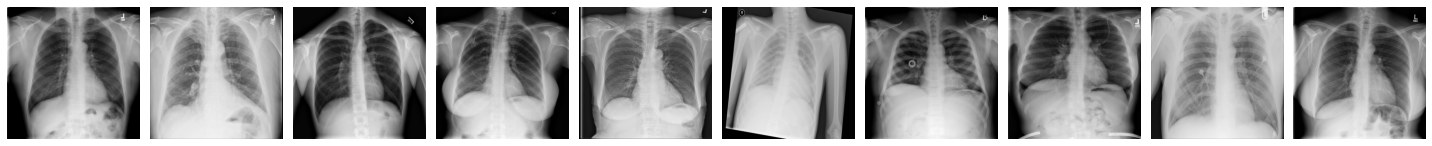

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(10, 512, 512, 3)

In [ ]:
imgs, labels=next(train_batches)
def plotImages(imgs_arr):
     fig,axes=plt.subplots(1,10,figsize=(20,20))
     axes=axes.flatten()
     for img,ax in zip(imgs_arr,axes):
         ax.imshow(img)
         ax.axis('off')
     plt.tight_layout()
     plt.show()
plotImages(imgs)
print(labels)
imgs.shape

**Early stopping and Saving the model**


I have applied early stopping by monitoring the validation loss for patience =3. If the validation loss does not improve(decreases) for the 3 consecutive epochs then the training will stop.
  

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
checkpointer = ModelCheckpoint( filepath='saved_models/model_cnn.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

# **1. Custom CNN:** 


First Model that I have applied is CNN model with 4 convolution layers and 2 dense layers with 1024 neurons each.



In [ ]:

model=Sequential([Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(512,512,3)),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  tf.keras.layers.Dropout(0.5),
                 
                  Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  tf.keras.layers.Dropout(0.5),

                  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  tf.keras.layers.Dropout(0.5),
                  
                  Flatten(), 
                  Dense(256,activation='relu'),
                  Dense(256,activation='relu'),

                  Dense(units=1,activation='sigmoid'),
                 ])
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 32)      0

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
start=time()
model_cnn=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
294/294 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8956
Epoch 00001: val_accuracy improved from -inf to 0.92976, saving model to saved_models\model_cnn.hdf5
294/294 [==============================] - 90s 258ms/step - loss: 0.2647 - accuracy: 0.8956 - val_loss: 0.5826 - val_accuracy: 0.9298 - lr: 1.0000e-04
Epoch 2/20
294/294 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9401
Epoch 00002: val_accuracy improved from 0.92976 to 0.94048, saving model to saved_models\model_cnn.hdf5
294/294 [==============================] - 53s 179ms/step - loss: 0.1595 - accuracy: 0.9401 - val_loss: 0.6031 - val_accuracy: 0.9405 - lr: 1.0000e-04
Epoch 3/20
294/294 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9588
Epoch 00003: val_accuracy improved from 0.94048 to 0.94405, saving model to saved_models\model_cnn.hdf5
294/294 [==============================] - 53s 180ms/step - loss: 0.1170 - accuracy: 0.9588 - val_los

**History**: Plotting model accuracy and loss for training and validation 

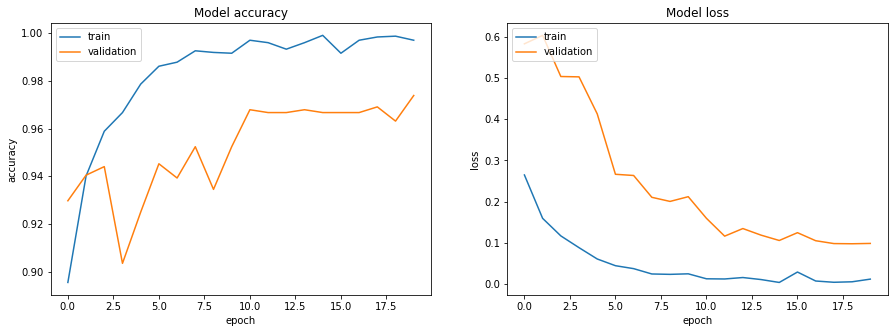

In [ ]:
plot_training(model_cnn)

**Test Accuracy**: Feeding the test batches for calculating test accuracy

In [ ]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
#test_batches.classes
model.load_weights('saved_models/model_cnn.hdf5')
score_cnn = model.evaluate(test_batches, verbose=1)
score_cnn

42/42 [==============================] - 8s 201ms/step - loss: 0.0918 - accuracy: 0.9690


[0.09180642664432526, 0.9690476059913635]

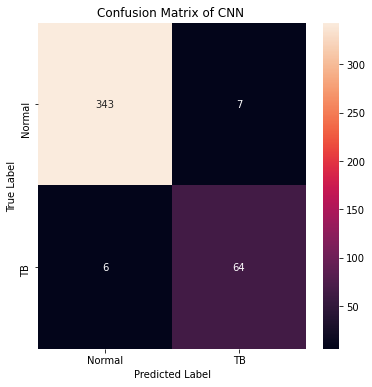

In [ ]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of CNN ")
plt.show()

In [ ]:
report_cnn = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_cnn = pd.DataFrame(report_cnn).transpose()
df_cnn

,precision,recall,f1-score,support
Normal,0.982808,0.980000,0.981402,350.000000
TB,0.901408,0.914286,0.907801,70.000000
accuracy,0.969048,0.969048,0.969048,0.969048
macro avg,0.942108,0.947143,0.944602,420.000000
weighted avg,0.969241,0.969048,0.969135,420.000000


# **2. VGG 16 Model**


Next, I have applied VGG 16 model through transfer learning.

In [ ]:

def vgg(input_shape, n_classes):
  input = Input(input_shape)
  x = Conv2D(64, 3, padding='same', activation='relu')(input)
  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)

  x = Conv2D(28, 3, padding='same', activation='relu')(x)
  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)

  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)

  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)

  output = Dense(1, activation='sigmoid')(x)
  model = Model(input, output)
  return model




In [ ]:
K.clear_session()
input_shape=(512,512,3)
n_classes=2
model=vgg(input_shape,n_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 28)      16156     
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 128)     32384     
                                                             

In [ ]:
checkpointer = ModelCheckpoint( filepath='saved_models/VGG_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Training of CNN VGG 16 model with 10 epochs
start=time()
VGG_model=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
294/294 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8643
Epoch 00001: val_accuracy improved from -inf to 0.90595, saving model to saved_models\VGG_model.hdf5
294/294 [==============================] - 92s 299ms/step - loss: 0.3585 - accuracy: 0.8643 - val_loss: 0.3085 - val_accuracy: 0.9060 - lr: 1.0000e-04
Epoch 2/20
294/294 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9007
Epoch 00002: val_accuracy did not improve from 0.90595
294/294 [==============================] - 72s 245ms/step - loss: 0.2378 - accuracy: 0.9007 - val_loss: 0.2102 - val_accuracy: 0.8940 - lr: 1.0000e-04
Epoch 3/20
294/294 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9299
Epoch 00003: val_accuracy did not improve from 0.90595
294/294 [==============================] - 71s 242ms/step - loss: 0.2022 - accuracy: 0.9299 - val_loss: 0.1930 - val_accuracy: 0.9048 - lr: 1.0000e-04
Epoch 4/20
294/294 [============================

**History of VGG 16**

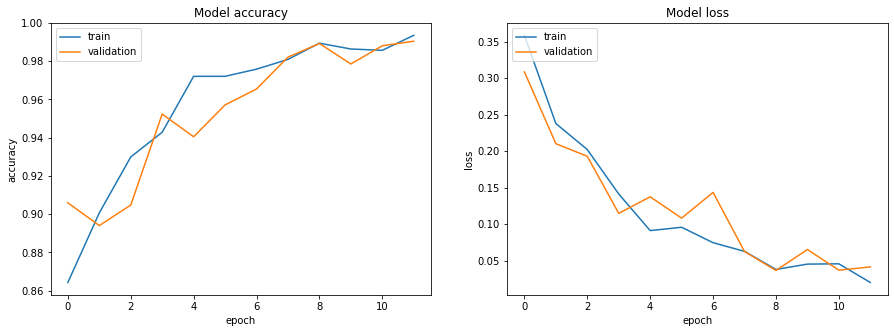

In [ ]:
plot_training(VGG_model)

**Test accuracy of VGG 16**

In [ ]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
#test_batches.classes
model.load_weights('saved_models/VGG_model.hdf5')
score_vgg = model.evaluate(test_batches, verbose=1)
score_vgg

42/42 [==============================] - 5s 128ms/step - loss: 0.0356 - accuracy: 0.9905


[0.035613592714071274, 0.9904761910438538]

**Confusion Matrix of VGG 16**

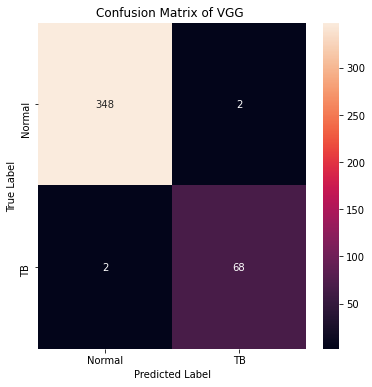

In [ ]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of VGG ")
plt.show()

**Different Metrics of VGG 16**

In [ ]:
report_vgg = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_vgg = pd.DataFrame(report_vgg).transpose()
df_vgg

,precision,recall,f1-score,support
Normal,0.994286,0.994286,0.994286,350.000000
TB,0.971429,0.971429,0.971429,70.000000
accuracy,0.990476,0.990476,0.990476,0.990476
macro avg,0.982857,0.982857,0.982857,420.000000
weighted avg,0.990476,0.990476,0.990476,420.000000


# **3. AlexNet**

In [ ]:
def alexnet(input_shape, n_classes):
  input = Input(input_shape)
  x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(256, 5, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  
  output = Dense(1, activation='sigmoid')(x)
  
  model = Model(input, output)
  return model

In [ ]:
K.clear_session()
input_shape=(512,512,3)
n_classes=2
model=alexnet(input_shape,n_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 96)      34944     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 256)      1024  

In [ ]:
checkpointer = ModelCheckpoint( filepath='saved_models/alex_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
start=time()
alex_model=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
294/294 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.9313
Epoch 00001: val_accuracy improved from -inf to 0.66071, saving model to saved_models\alex_model.hdf5
294/294 [==============================] - 55s 181ms/step - loss: 0.6542 - accuracy: 0.9313 - val_loss: 1.9810 - val_accuracy: 0.6607 - lr: 1.0000e-04
Epoch 2/20
294/294 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9599
Epoch 00002: val_accuracy improved from 0.66071 to 0.80952, saving model to saved_models\alex_model.hdf5
294/294 [==============================] - 55s 186ms/step - loss: 0.2238 - accuracy: 0.9599 - val_loss: 0.9460 - val_accuracy: 0.8095 - lr: 1.0000e-04
Epoch 3/20
294/294 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9782
Epoch 00003: val_accuracy improved from 0.80952 to 0.86190, saving model to saved_models\alex_model.hdf5
294/294 [==============================] - 56s 189ms/step - loss: 0.0979 - accuracy: 0.9782 - val_

**History of Alex Model**

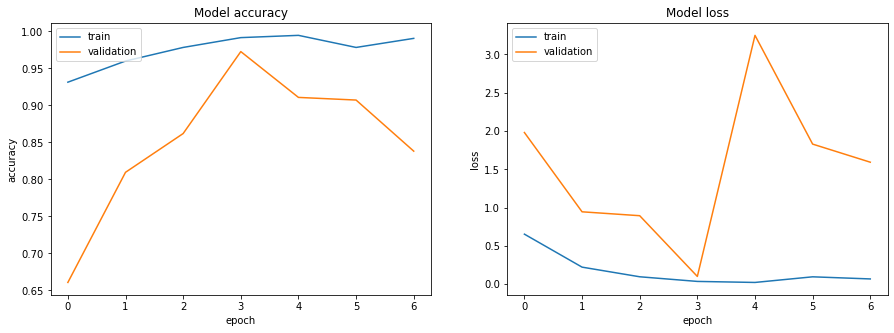

In [ ]:
plot_training(alex_model)

**Test Accuracy of Alex Model**

In [ ]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
model.load_weights('saved_models/alex_model.hdf5')
score_alex = model.evaluate(test_batches, verbose=1)
score_alex

42/42 [==============================] - 5s 126ms/step - loss: 0.0674 - accuracy: 0.9810


[0.06740894168615341, 0.9809523820877075]

**Confusion Matrix of Alex Model**

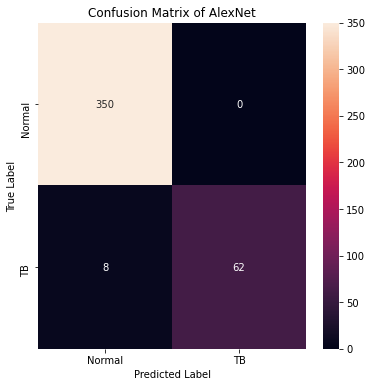

In [ ]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of AlexNet")
plt.show()

**Different Metrics of Alex Model**

In [ ]:
report_alex = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_alex = pd.DataFrame(report_alex).transpose()
df_alex

,precision,recall,f1-score,support
Normal,0.977654,1.000000,0.988701,350.000000
TB,1.000000,0.885714,0.939394,70.000000
accuracy,0.980952,0.980952,0.980952,0.980952
macro avg,0.988827,0.942857,0.964047,420.000000
weighted avg,0.981378,0.980952,0.980483,420.000000


# **4. Custom ANN Model-1**


Next, I have applied ANN model with 5 hidden layers.

In [ ]:
model=Sequential()
model.add(Flatten(input_shape=(512,512,3)))

model.add(Dense(128,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(72,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(36,activation='relu'))
tf.keras.layers.Dropout(0.5),



model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 786432)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               100663424 
                                                                 
 dense_4 (Dense)             (None, 72)                9288      
                                                                 
 dense_5 (Dense)             (None, 36)                2628      
                                                                 
 dense_6 (Dense)             (None, 1)                 37        
                                                                 
Total params: 100,675,377
Trainable params: 100,675,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpointer = ModelCheckpoint( filepath='saved_models/ann_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
start=time()
ann_model=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
294/294 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.8660
Epoch 00001: val_accuracy improved from -inf to 0.85595, saving model to saved_models\ann_model.hdf5
294/294 [==============================] - 49s 165ms/step - loss: 0.7005 - accuracy: 0.8660 - val_loss: 1.8129 - val_accuracy: 0.8560 - lr: 1.0000e-04
Epoch 2/20
294/294 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.9051
Epoch 00002: val_accuracy improved from 0.85595 to 0.96310, saving model to saved_models\ann_model.hdf5
294/294 [==============================] - 50s 171ms/step - loss: 0.3877 - accuracy: 0.9051 - val_loss: 0.1221 - val_accuracy: 0.9631 - lr: 1.0000e-04
Epoch 3/20
294/294 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9361
Epoch 00003: val_accuracy did not improve from 0.96310
294/294 [==============================] - 46s 155ms/step - loss: 0.1846 - accuracy: 0.9361 - val_loss: 0.1053 - val_accuracy: 0.9595 - lr: 1.0000e-04

**History of ANN**

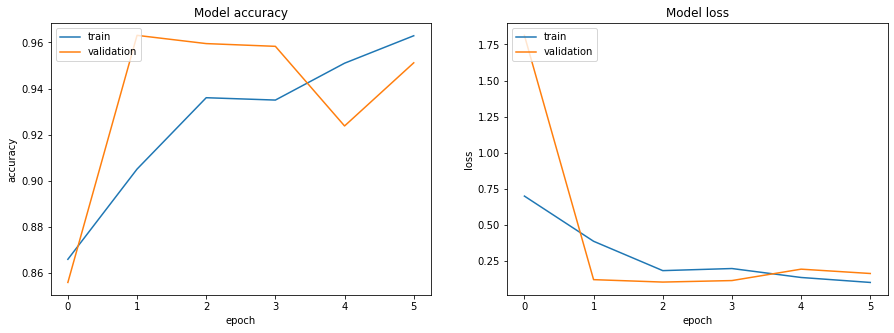

In [ ]:
plot_training(ann_model)

**Test Accuracy of ANN**

In [ ]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
model.load_weights('saved_models/ann_model.hdf5')
score_ann = model.evaluate(test_batches, verbose=1)
score_ann

42/42 [==============================] - 5s 120ms/step - loss: 0.1095 - accuracy: 0.9619


[0.10951929539442062, 0.961904764175415]

**Confusion Matrix of ANN**

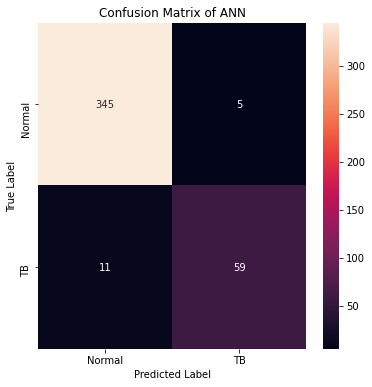

In [ ]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of ANN")
plt.show()

In [ ]:
report_ann = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_ann = pd.DataFrame(report_ann).transpose()
df_ann

,precision,recall,f1-score,support
Normal,0.969101,0.985714,0.977337,350.000000
TB,0.921875,0.842857,0.880597,70.000000
accuracy,0.961905,0.961905,0.961905,0.961905
macro avg,0.945488,0.914286,0.928967,420.000000
weighted avg,0.961230,0.961905,0.961214,420.000000


# **5. Custom ANN Model-2**


In [ ]:
model=Sequential()
model.add(Flatten(input_shape=(512,512,3)))

model.add(Dense(256,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(128,activation='relu'))
tf.keras.layers.Dropout(0.5),

model.add(Dense(72,activation='relu'))
tf.keras.layers.Dropout(0.5),


model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 786432)            0         
                                                                 
 dense_7 (Dense)             (None, 256)               201326848 
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 72)                9288      
                                                                 
 dense_10 (Dense)            (None, 1)                 73        
                                                                 
Total params: 201,369,105
Trainable params: 201,369,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpointer = ModelCheckpoint( filepath='saved_models/ann_2_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
start=time()
ann_model_2=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
294/294 [==============================] - ETA: 0s - loss: 1.2349 - accuracy: 0.8741
Epoch 00001: val_accuracy improved from -inf to 0.92619, saving model to saved_models\ann_2_model.hdf5
294/294 [==============================] - 52s 175ms/step - loss: 1.2349 - accuracy: 0.8741 - val_loss: 0.3506 - val_accuracy: 0.9262 - lr: 1.0000e-04
Epoch 2/20
294/294 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.9129
Epoch 00002: val_accuracy improved from 0.92619 to 0.95357, saving model to saved_models\ann_2_model.hdf5
294/294 [==============================] - 54s 185ms/step - loss: 0.4712 - accuracy: 0.9129 - val_loss: 0.1685 - val_accuracy: 0.9536 - lr: 1.0000e-04
Epoch 3/20
294/294 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.9058
Epoch 00003: val_accuracy did not improve from 0.95357
294/294 [==============================] - 48s 162ms/step - loss: 0.5628 - accuracy: 0.9058 - val_loss: 1.2162 - val_accuracy: 0.8071 - lr: 1.0000

**History of ANN-2 Model**

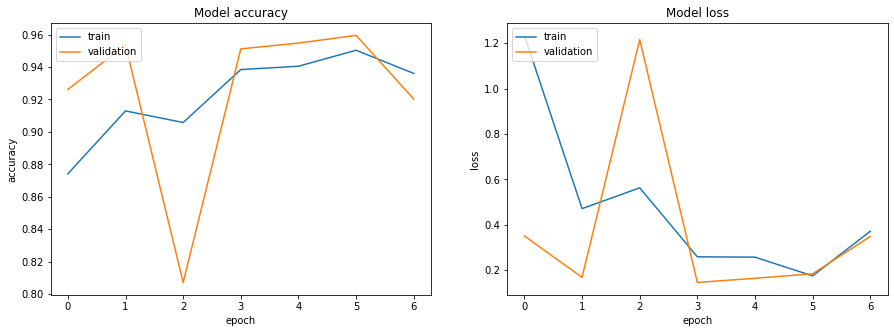

In [ ]:
plot_training(ann_model_2)

**Test Accuracy of ANN-2 Model**

In [ ]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
model.load_weights('saved_models/ann_2_model.hdf5')
score_ann_2 = model.evaluate(test_batches, verbose=1)
score_ann_2

42/42 [==============================] - 5s 120ms/step - loss: 0.1634 - accuracy: 0.9667


[0.1633538007736206, 0.9666666388511658]

**Confusion Matrix of ANN-2**

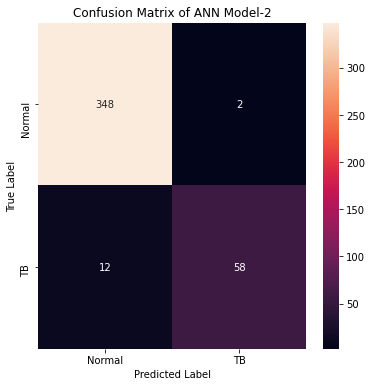

In [ ]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of ANN Model-2")
plt.show()

**Different Metrics of ANN-2**

In [ ]:
report_ann_2 = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_ann_2 = pd.DataFrame(report_ann_2).transpose()
df_ann_2

,precision,recall,f1-score,support
Normal,0.966667,0.994286,0.980282,350.000000
TB,0.966667,0.828571,0.892308,70.000000
accuracy,0.966667,0.966667,0.966667,0.966667
macro avg,0.966667,0.911429,0.936295,420.000000
weighted avg,0.966667,0.966667,0.965619,420.000000


# **6. Custom ANN Model-3**


In [ ]:
model=Sequential()
model.add(Flatten(input_shape=(512,512,3)))

model.add(Dense(256,activation='relu'))

model.add(Dense(256,activation='relu'))

model.add(Dense(128,activation='relu'))

model.add(Dense(128,activation='relu'))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 786432)            0         
                                                                 
 dense_11 (Dense)            (None, 256)               201326848 
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 201,442,177
Trainable params: 201,442,17

In [ ]:
checkpointer = ModelCheckpoint( filepath='saved_models/ann_3_model.hdf5',monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
start=time()
ann_model_3=model.fit(x=train_batches, validation_data=valid_batches,epochs=20,verbose=1,callbacks=callbacks)
end=time()
print("\n\nTime required to train the model =", (end-start)/60," Mins")

Epoch 1/20
294/294 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.8667
Epoch 00001: val_accuracy improved from -inf to 0.90714, saving model to saved_models\ann_3_model.hdf5
294/294 [==============================] - 51s 173ms/step - loss: 0.7173 - accuracy: 0.8667 - val_loss: 0.2611 - val_accuracy: 0.9071 - lr: 1.0000e-04
Epoch 2/20
294/294 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.9156
Epoch 00002: val_accuracy improved from 0.90714 to 0.92976, saving model to saved_models\ann_3_model.hdf5
294/294 [==============================] - 52s 178ms/step - loss: 0.3023 - accuracy: 0.9156 - val_loss: 0.2172 - val_accuracy: 0.9298 - lr: 1.0000e-04
Epoch 3/20
294/294 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 0.9224
Epoch 00003: val_accuracy did not improve from 0.92976
294/294 [==============================] - 48s 163ms/step - loss: 0.3300 - accuracy: 0.9224 - val_loss: 0.6755 - val_accuracy: 0.8821 - lr: 1.0000

**History of Custom ANN Model-3**

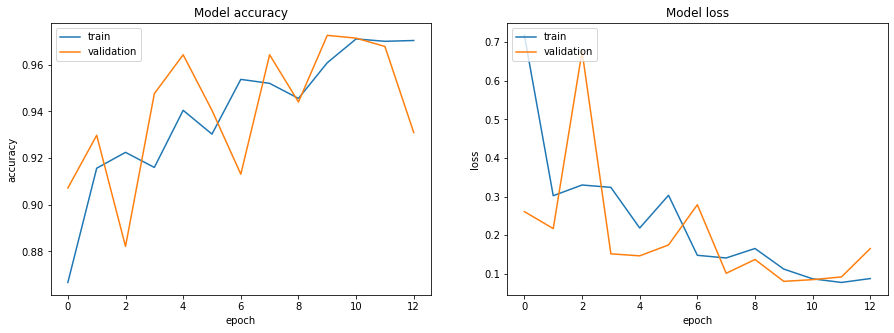

In [ ]:
plot_training(ann_model_3)

**Test Accuracy of Custom ANN Model-3**

In [ ]:
test_img,test_labels=next(test_batches)
#plotImages(test_img)
#print(test_labels)
model.load_weights('saved_models/ann_3_model.hdf5')
score_ann_3 = model.evaluate(test_batches, verbose=1)
score_ann_3

42/42 [==============================] - 5s 126ms/step - loss: 0.0758 - accuracy: 0.9714


[0.07579648494720459, 0.9714285731315613]

**Confusion Matrix of ANN Model-3**

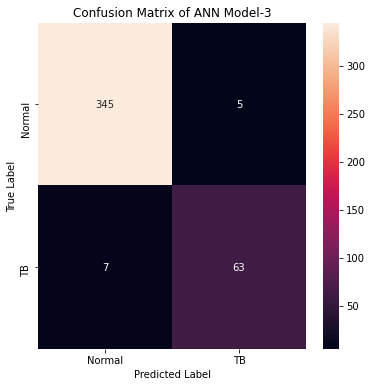

In [ ]:
y_pred=model.predict(test_batches)
y_pred
y_pred=(y_pred>0.5)
cm=confusion_matrix(test_batches.classes,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
Patient_labels = ['Normal', 'TB']
ax.yaxis.set_ticklabels(Patient_labels)
plt.title("Confusion Matrix of ANN Model-3")
plt.show()

**Different Metrics of ANN Model-3**

In [ ]:
report_ann_3 = classification_report(test_batches.classes, y_pred, target_names=Patient_labels, output_dict=True)
df_ann_3 = pd.DataFrame(report_ann_3).transpose()
df_ann_3

,precision,recall,f1-score,support
Normal,0.980114,0.985714,0.982906,350.000000
TB,0.926471,0.900000,0.913043,70.000000
accuracy,0.971429,0.971429,0.971429,0.971429
macro avg,0.953292,0.942857,0.947975,420.000000
weighted avg,0.971173,0.971429,0.971262,420.000000


In [ ]:
#model=tf.keras.models.load_model('/content/drive/MyDrive/TB Data.zip (Unzipped Files)/TB Data/saved_models/model_cnn.hdf5', compile=True)